# 라이브러리

In [1]:

# MIT-BIH 부정맥 데이터베이스 분석 및 R-peak 데이터셋 생성
import os
import wfdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
import scipy.signal as signal
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os 
from util import *
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from torch.utils.data import Dataset
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error
# CUDA 오류 디버깅을 위한 환경 변수 설정
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


# QRS 검출 모델 및 데이터셋 정의

In [2]:
class CBR(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=7, stride=1, padding=3):
        super(CBR, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, channels, kernel_size=7, padding=3, reduction=16):
        super(ResidualBlock, self).__init__()
        self.cbr1 = CBR(channels, channels, kernel_size, 1, padding)
        self.cbr2 = CBR(channels, channels, kernel_size, 1, padding)
        
      
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool1d(1), 
            nn.Conv1d(channels, channels // reduction, kernel_size=1),  
            nn.ReLU(inplace=True),
            nn.Conv1d(channels // reduction, channels, kernel_size=1),  
            nn.Sigmoid()  
        )
        
    def forward(self, x):
        residual = x
        x = self.cbr1(x)
        x = self.cbr2(x)
        
        # Squeeze and Excitation 적용
        se_weight = self.se(x)
        x = x * se_weight  # 채널별 가중치 적용
        
        x = x + residual  
        return x

class EncodingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(EncodingBlock, self).__init__()
        self.cbr = CBR(in_channels, out_channels, stride=stride)
        self.res_blocks = nn.Sequential(
            ResidualBlock(out_channels),
            ResidualBlock(out_channels),
            ResidualBlock(out_channels),
            ResidualBlock(out_channels)
        )
        
    def forward(self, x):
        x = self.cbr(x)
        x = self.res_blocks(x)
        return x

class DecodingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, reduction=16):
        super(DecodingBlock, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='linear', align_corners=True)
        self.cbr = CBR(in_channels, out_channels)
        
        # Squeeze-and-Excitation 모듈 추가
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),  
            nn.Conv1d(out_channels, out_channels // reduction, kernel_size=1),  
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels // reduction, out_channels, kernel_size=1),  
            nn.Sigmoid() 
        )
        
    def forward(self, x, skip):
        x = self.upsample(x)
        # 크기 불일치 문제 해결을 위해 skip 연결 전에 크기 확인 및 조정
        if x.size(2) != skip.size(2):
            if x.size(2) > skip.size(2):
                x = x[:, :, :skip.size(2)]
            else:
                skip = skip[:, :, :x.size(2)]
        x = torch.cat([x, skip], dim=1)
        x = self.cbr(x)
        
        # Squeeze-and-Excitation 적용
        se_weight = self.se(x)
        x = x * se_weight  # 채널별 가중치 적용
        
        return x
    
class UNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=1):
        super(UNet, self).__init__()
        
        self.enc1 = EncodingBlock(in_channels, 16)
        self.enc2 = EncodingBlock(16, 32)
        self.enc3 = EncodingBlock(32, 48)
        self.enc4 = EncodingBlock(48, 64)
        
        # 디코더 블록
        self.dec1 = DecodingBlock(64 + 48, 48)
        self.dec2 = DecodingBlock(48 + 32, 32)
        self.dec3 = DecodingBlock(32 + 16, 16)
        
        self.conv_final = nn.Conv1d(16, num_classes, kernel_size=1)
        
    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        
        dec1 = self.dec1(enc4, enc3)
        dec2 = self.dec2(dec1, enc2)
        dec3 = self.dec3(dec2, enc1)
        
        # 마지막 컨볼루션 레이어로 세그멘테이션 마스크 생성
        output = self.conv_final(dec3)
        
        return output

In [3]:
# U-Net을 위한 데이터셋 (ECG 신호 → QRS 마스크)
class ECGDataset(Dataset):
    def __init__(self, ecg_signals, qrs_masks, rpeaks, sample_length=500):
        self.ecg_signals = ecg_signals
        self.qrs_masks = qrs_masks
        self.rpeaks = rpeaks
        self.sample_length = sample_length
    def __len__(self):
        return len(self.ecg_signals)
    
    def __getitem__(self, idx):
        ecg_signal = self.ecg_signals[idx].astype(np.float32)
        qrs_mask = self.qrs_masks[idx].astype(np.float32)
        rpeaks = self.rpeaks[idx]
        ecg_signal = preprocess_ecg(ecg_signal, 500)
        
        ecg_signal = torch.tensor(ecg_signal, dtype=torch.float32)
        qrs_mask = torch.tensor(qrs_mask, dtype=torch.float32)
        
        # 차원 조정 (1, 5000 형태로)
        ecg_signal = ecg_signal.view(1, 5000)  # 1, 5000 형태로 변경
        qrs_mask = qrs_mask.view(1, 5000)  # 1, 5000 형태로 변경
        
        return ecg_signal, qrs_mask, rpeaks
    
def custom_collate_fn(batch):
    """
    통합 데이터셋 collate 정의
    """
    ecgs = [item[0] for item in batch]
    masks = [item[1] for item in batch]
    # rpeaks는 배치로 묶지 않고 리스트 그대로 유지
    rpeaks = [item[2] for item in batch]
    
    # 텐서로 변환하여 배치 생성
    ecgs = torch.stack(ecgs)
    masks = torch.stack(masks)
    
    return ecgs, masks, rpeaks[0]


# 데이터 로드 함수
def load_mitbih_record(record_num):
    """
    MIT-BIH 데이터베이스에서 특정 레코드를 로드
    
    Args:
        record_num (int): 레코드 번호 (예: 100, 101 등)
    
    Returns:
        signals, fields: 신호 데이터와 메타데이터
    """
    record_name = f"{mitdb_path}/{record_num}"
    signals, fields = wfdb.rdsamp(record_name)
    
    # 500Hz로 리샘플링
    fs_original = fields['fs']
    fs_target = 500
    
    if fs_original != fs_target:
        # 리샘플링 비율 계산
        resampling_factor = fs_target / fs_original
        
        new_length = int(len(signals) * resampling_factor)
        
        resampled_signals = np.zeros((new_length, signals.shape[1]))
        for i in range(signals.shape[1]):
            resampled_signals[:, i] = signal.resample(signals[:, i], new_length)
        
        fields['fs'] = fs_target
        
        return resampled_signals, fields
    
    return signals, fields

# 어노테이션 로드 함수
def load_annotations(record_num):
    """
    MIT-BIH 데이터베이스에서 특정 레코드의 어노테이션을 로드
    
    Args:
        record_num (int): 레코드 번호
    
    Returns:
        ann: 어노테이션 객체
    """
    record_name = f"{mitdb_path}/{record_num}"
    ann = wfdb.rdann(record_name, 'atr')
    
    # 어노테이션 위치를 500Hz에 맞게 조정
    fs_original = 360  # MIT-BIH의 원래 샘플링 주파수
    fs_target = 500
    
    if fs_original != fs_target:
        # 어노테이션 위치 조정
        resampling_factor = fs_target / fs_original
        ann.sample = np.array([int(s * resampling_factor) for s in ann.sample])
    
    return ann 

# QRS 복합체 검출을 위한 데이터셋 생성 함수
def create_qrs_segmentation_dataset(records, window_size=5000, qrs_width=100):
    """
    QRS 복합체 검출을 위한 세그멘테이션 데이터셋 생성
    
    Args:
        records: 사용할 ECG 레코드 목록
        window_size: 윈도우 크기 (기본값 5000)
        qrs_width: QRS 복합체의 평균 너비 (픽셀 단위)
    
    Returns:
        X: ECG 신호 윈도우 배열 (shape: [B, 1, 5000]) - B는 배치 크기
        y: 세그멘테이션 마스크 (shape: [B, 5000]) - 1: QRS 복합체, 0: 배경
    """
    X = []
    y = []
    Z = []
    
    for record in records:
        ecg_signal, fields = load_mitbih_record(record)
        ann = load_annotations(record)
        
        # R-peak 위치 가져오기
        rpeak_locations = []
        for i, symbol in enumerate(ann.symbol):
            if symbol in ['N', 'L', 'R', 'V', 'A']:  # 정상 및 비정상 QRS 복합체 포함
                rpeak_locations.append(ann.sample[i])
        
        # 윈도우 생성
        for i in range(0, len(ecg_signal) - window_size, window_size // 2):  # 50% 오버랩
            window = ecg_signal[i:i+window_size, 0]  # 첫 번째 채널만 사용 Lead I
            
            # 세그멘테이션 마스크 생성
            mask = np.zeros(window_size)
            
            # 윈도우 내 R-peak 위치 저장
            window_rpeaks = []
            
            # 윈도우 내의 모든 R-peak에 대해 QRS 복합체 영역 마킹
            for rpeak in rpeak_locations:
                if i <= rpeak < i + window_size:
                    # 윈도우 내 상대적 R-peak 위치 저장
                    window_rpeaks.append(rpeak - i)
                    
                    # QRS 복합체는 R-peak를 중심으로 qrs_width/2 픽셀 양쪽으로 확장
                    qrs_start = max(0, rpeak - i - qrs_width // 2)
                    qrs_end = min(window_size, rpeak - i + qrs_width // 2)
                    mask[qrs_start:qrs_end] = 1
            
            # R-peak가 없는 윈도우는 건너뛰기
            if np.sum(mask) == 0:
                continue
                
            # 채널 차원 추가 (B, 1, 5000) 형태로 만들기
            X.append(window.reshape(1, -1))
            y.append(mask)
            Z.append(window_rpeaks)
    # X는 (B, 1, 5000) 형태, y는 (B, 5000) 형태로 변환
    X = np.array(X)
    y = np.array(y)
    
    return X, y, Z

In [4]:
# tol 일반적으로 활용하는 오차 범위 50 ms
def tolerance_matching(true_peaks, predicted_peaks, fs=500, tol=50):
    tolerance_samples = int((tol / 1000) * fs)
    matched_predicted = set()
    TP, FP, FN = 0, 0, 0
    for t in true_peaks:
        if len(predicted_peaks) == 0:
            FN += 1
            continue

        distances = np.abs(np.array(predicted_peaks) - t)
        min_dist_idx = np.argmin(distances)
        min_dist = distances[min_dist_idx]

        if min_dist <= tolerance_samples:
            TP += 1
            matched_predicted.add(min_dist_idx)
        else:
            FN += 1

    FP = len(predicted_peaks) - len(matched_predicted)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return {
        "TP": TP,
        "FP": FP,
        "FN": FN,
        "Precision": precision,
        "Recall": recall,
        "F1_score": f1
    }
    
# QRS 회귀 모델 학습 함수
def train_qrs_regression(model, train_loader, val_loader, device, epochs=100, early_stopping_patience=5):
    model = model.to(device)
    
    # MSE 손실 함수 및 옵티마이저 설정
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=2)
    
    best_val_loss = float('inf')
    early_stopping_counter = 0
    
    for epoch in range(epochs):
        # 학습 모드
        model.train()
        train_loss = 0.0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # 검증 모드
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        # 학습률 조정
        scheduler.step(val_loss)
        
        # 모델 저장 및 early stopping 확인
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_qrs_regression_model.pth')
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print(f'Early stopping 발동: {early_stopping_patience}회 동안 검증 손실이 개선되지 않았습니다.')
                break
        
        print(f'에포크 {epoch+1}/{epochs}, 학습 손실: {train_loss/len(train_loader):.4f}, 검증 손실: {val_loss/len(val_loader):.4f}')


# 모델 학습 파라미터 설정
def train_unet(model, train_loader, val_loader, device, epochs=100, early_stopping_patience=5):
    model = model.to(device)
    
    # # 클래스 불균형이 심한 경우 가중치 적용
    # pos_weight = torch.tensor([5.0])  # QRS 구간이 적을 경우 더 높은 가중치 부여
    # criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    criterion = FocalLoss()
    # criterion = nn.BCELoss()
    
    # 참고 자료의 최적화 기법 적용
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.8, patience=2
    )
    
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        # 학습 모드
        model.train()
        train_loss = 0.0
        
        for inputs, targets, _ in train_loader:
            inputs, targets = inputs.to(device), targets.to(device) 
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # 검증 모드
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for inputs, targets, _ in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        # 학습률 조정
        scheduler.step(val_loss)
        
        # 모델 저장 및 Early Stopping 적용
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_unet_model.pth')
            patience_counter = 0  # 개선되었으므로 카운터 초기화
        else:
            patience_counter += 1  # 개선되지 않았으므로 카운터 증가
        
        print(f'에포크 {epoch+1}/{epochs}, 학습 손실: {train_loss/len(train_loader):.4f}, 검증 손실: {val_loss/len(val_loader):.4f}')
        
        # Early Stopping 확인
        if patience_counter >= early_stopping_patience:
            print(f'Early Stopping: {early_stopping_patience}회 동안 검증 손실이 개선되지 않았습니다.')
            break


# 모델 평가 함수 정의
def evaluate_model_unet(model, test_loader, device):
    """
    모델을 평가하고 성능 지표를 계산하는 함수
    
    Args:
        model: 평가할 모델
        test_loader: 테스트 데이터 로더
        device: 연산을 수행할 장치 (CPU 또는 GPU)
    
    Returns:
        평가 지표 (정확도, 정밀도, 재현율, F1 점수)
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_outputs = []
    
    # 테스트 데이터에 대한 예측 수행
    with torch.no_grad():
        for inputs, labels, _ in tqdm(test_loader, desc="모델 평가 중"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            
            # 예측 결과와 실제 레이블 수집
            all_preds.extend(probs.cpu().numpy().flatten())
            all_outputs.extend(outputs.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())
    
    # 수집된 데이터를 numpy 배열로 변환
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_outputs = np.array(all_outputs)
    
    # 최적의 임계값 찾기
    thresholds = np.arange(0.1, 0.9, 0.05)
    best_f1 = 0
    best_threshold = 0.5
    
    for threshold in tqdm(thresholds, desc="임계값 최적화 중"):
        binary_preds = (all_preds > threshold).astype(int)
        f1 = f1_score(all_labels, binary_preds, average='binary')
        
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    # 최적 임계값으로 최종 예측
    final_preds = (all_preds > best_threshold).astype(int)
    
    # 성능 지표 계산
    accuracy = accuracy_score(all_labels, final_preds)
    precision = precision_score(all_labels, final_preds, average='binary')
    recall = recall_score(all_labels, final_preds, average='binary')
    f1 = f1_score(all_labels, final_preds, average='binary')
    
    print(f"최적 임계값: {best_threshold:.3f}")
    print(f"정확도: {accuracy:.4f}")
    print(f"정밀도: {precision:.4f}")
    print(f"재현율: {recall:.4f}")
    print(f"F1 점수: {f1:.4f}")
    
    return accuracy, precision, recall, f1, best_threshold

# 모델 평가 함수 정의
def evaluate_model_rpeak(model, test_loader, device):
    """
    모델을 평가하고 성능 지표를 계산하는 함수
    
    Args:
        model: 평가할 모델
        test_loader: 테스트 데이터 로더
        device: 연산을 수행할 장치 (CPU 또는 GPU)
    
    Returns:
        평가 지표 (RMSE, MAE)
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    # 테스트 데이터에 대한 예측 수행
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="모델 평가 중"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            
            # 예측 결과와 실제 레이블 수집
            all_preds.extend(outputs.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())
    
    # 수집된 데이터를 numpy 배열로 변환
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # RMSE 계산
    rmse = np.sqrt(mean_squared_error(all_labels, all_preds))
    # MAE 계산
    mae = mean_absolute_error(all_labels, all_preds)
    
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    
    return rmse, mae


In [5]:
# MIT-BIH 데이터가 저장된 폴더
mitdb_path = "../mit-bih-arrhythmia-database"

In [6]:

files = os.listdir(mitdb_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 확장자를 제외한 파일 이름만 추출
records_to_use = []
for file in files:
    # 확장자가 있는 경우 제거
    file_name = os.path.splitext(file)[0]
    # 중복 제거 (같은 이름의 다른 확장자 파일이 있을 수 있음)
    if file_name not in records_to_use:
        records_to_use.append(file_name)
records_to_use.remove('102-0')

# QRS 복합체 세그멘테이션 데이터셋 생성
X, y, Z = create_qrs_segmentation_dataset(records_to_use, window_size=5000, qrs_width=100)

X_processed = np.array([x[0] for x in tqdm(X, desc="ECG 전처리 중")])

# 훈련 데이터와 나머지 데이터 분할 (80% vs 20%)
X_train, X_temp, y_train, y_temp, Z_train, Z_temp = train_test_split(X_processed, y, Z, test_size=0.2, random_state=42)
# 검증 데이터와 테스트 데이터 분할 (각각 10%)
X_val, X_test, y_val, y_test, Z_val, Z_test = train_test_split(X_temp, y_temp, Z_temp, test_size=0.5, random_state=42)

# U-Net 모델을 위한 데이터셋 및 데이터 로더 생성
train_dataset = ECGDataset(X_train, y_train, Z_train)
val_dataset = ECGDataset(X_val, y_val, Z_val)
test_dataset = ECGDataset(X_test, y_test, Z_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=custom_collate_fn, num_workers=8, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=custom_collate_fn, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=custom_collate_fn, num_workers=8, pin_memory=True)

unet_model = UNet(in_channels=1, num_classes=1).to(device)


ECG 전처리 중: 100%|██████████| 16277/16277 [00:00<00:00, 919309.56it/s]


# QRS 검출 모델 학습

In [7]:
train_unet(unet_model, train_loader, val_loader, device, epochs=50)

# 모델 저장 
torch.save(unet_model.state_dict(), 'best_unet_model.pth')

NameError: name 'FocalLoss' is not defined

# QRS 검출 모델 검증

In [8]:
unet_model.load_state_dict(torch.load('best_unet_model.pth'))


/tmp/ipykernel_1480871/836255210.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet_model.load_state_dict(torch.load('best_unet_model.pth'))


<All keys matched successfully>

In [9]:
accuracy, precision, recall, f1, best_threshold = evaluate_model_unet(unet_model, test_loader, device)

임계값 최적화 중: 100%|██████████| 16/16 [01:17<00:00,  4.83s/it]


최적 임계값: 0.350
정확도: 0.9573
정밀도: 0.9208
재현율: 0.9020
F1 점수: 0.9113


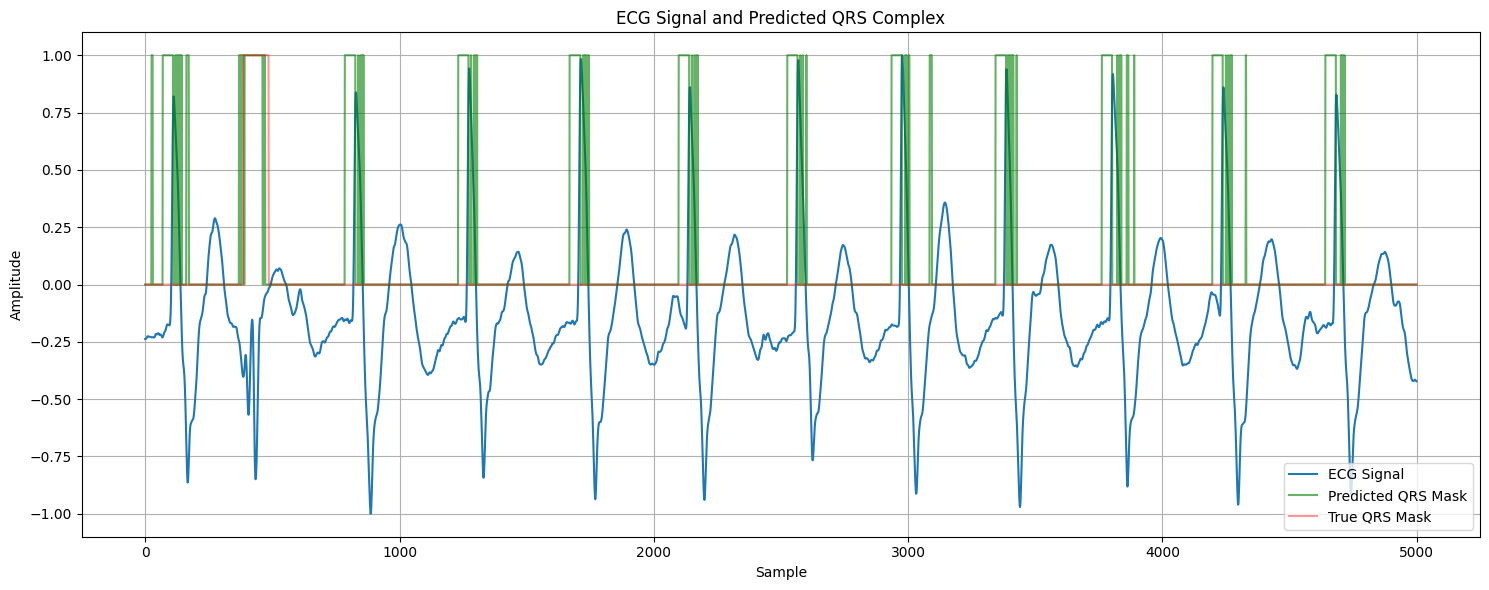

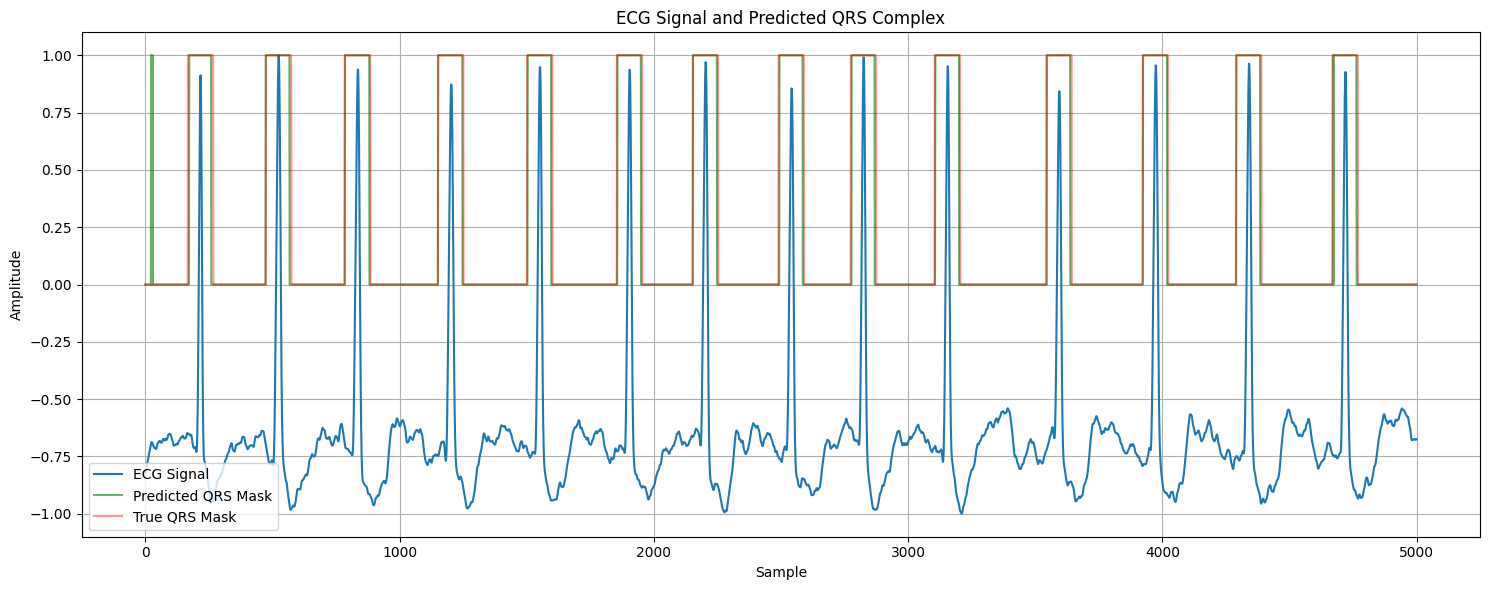

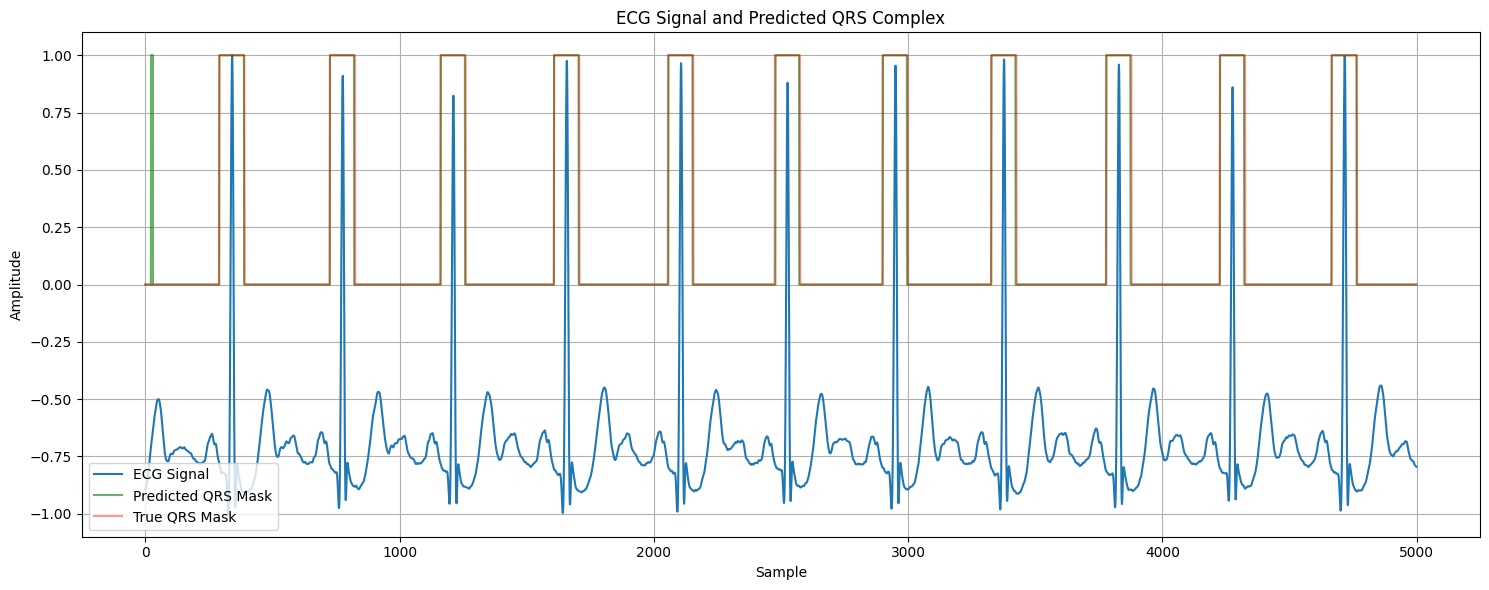

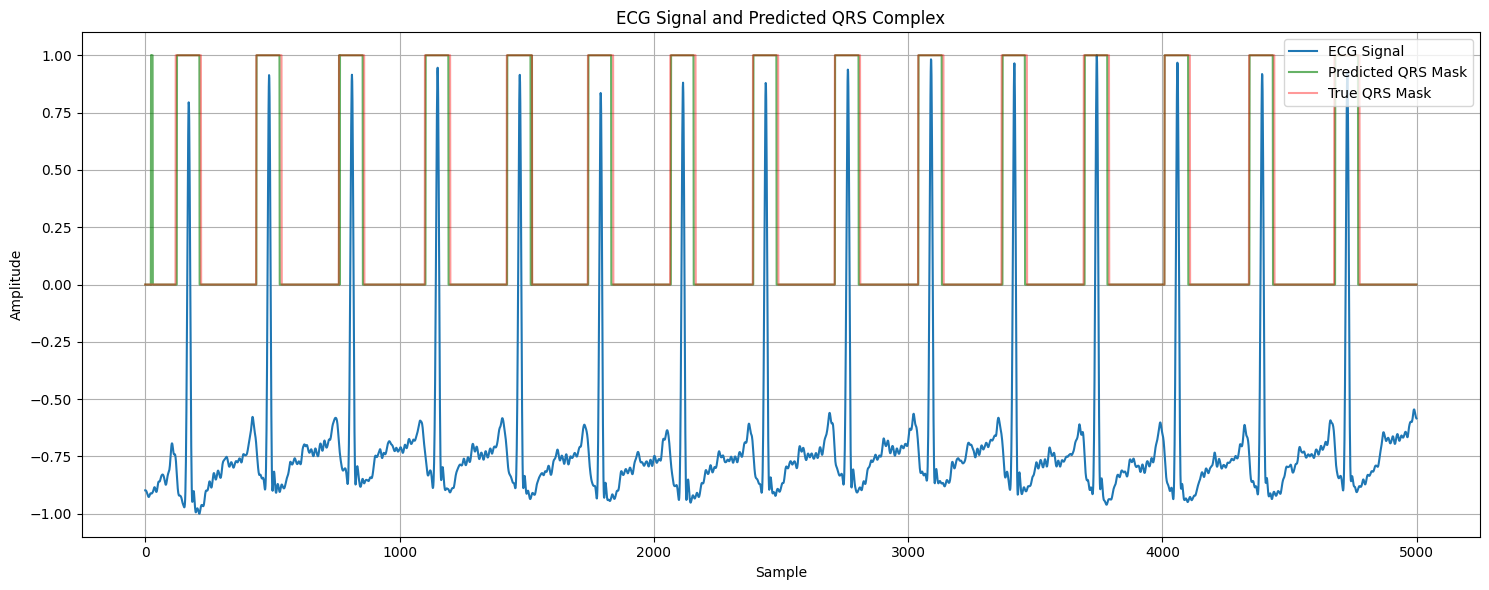

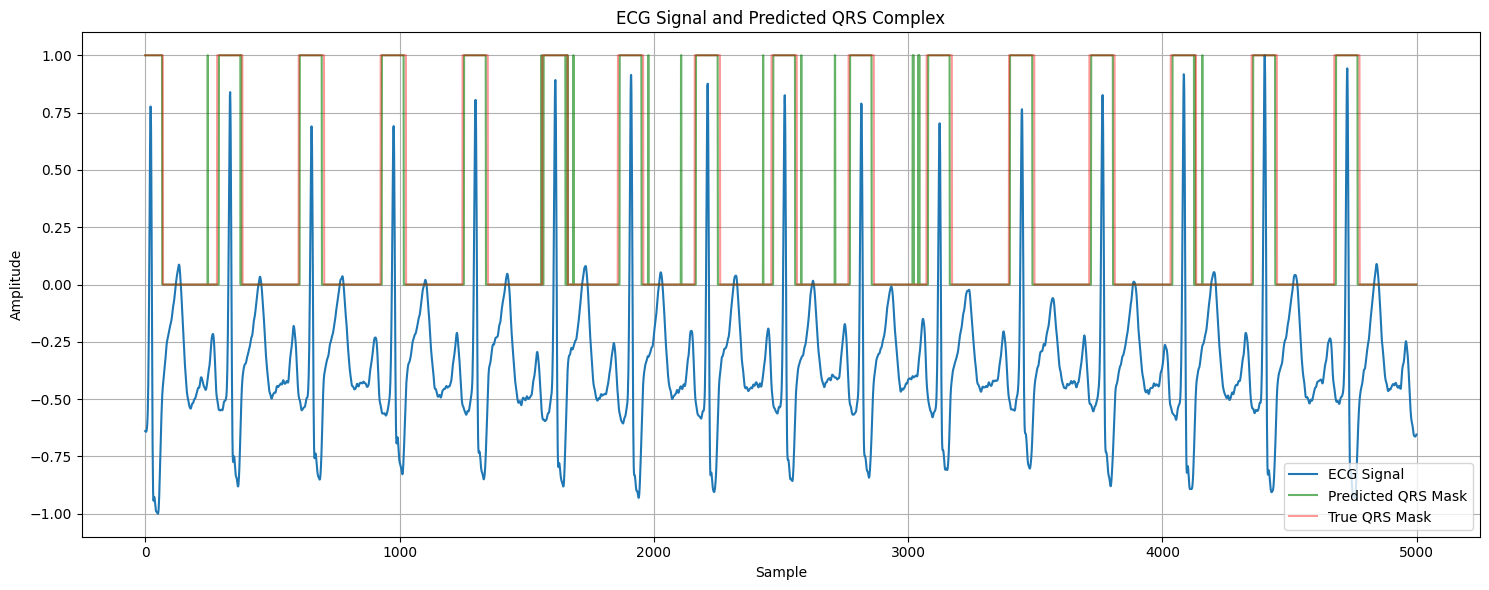

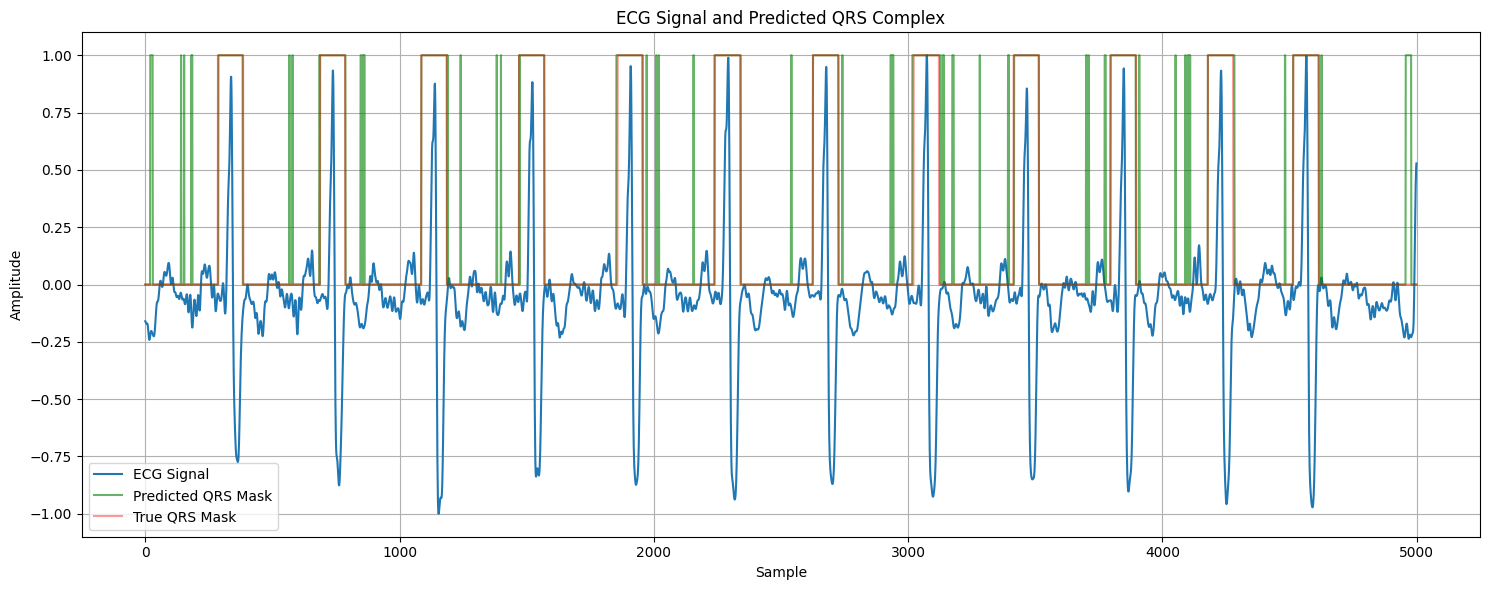

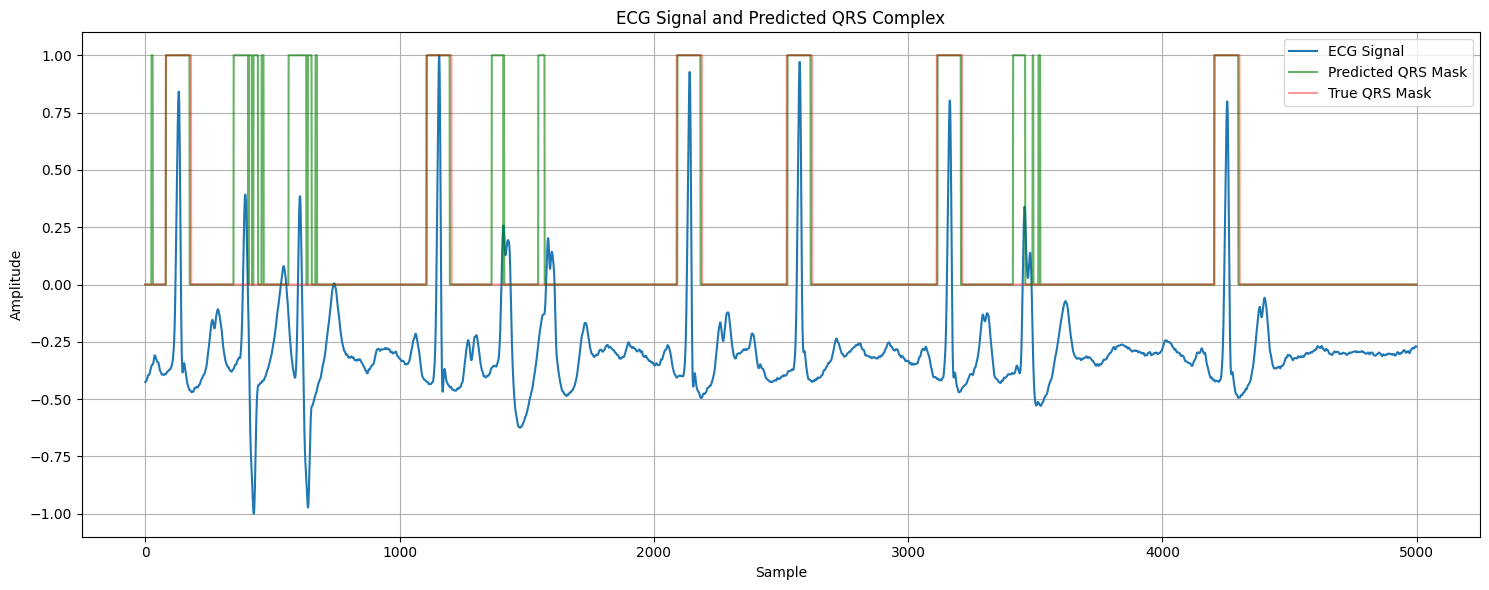

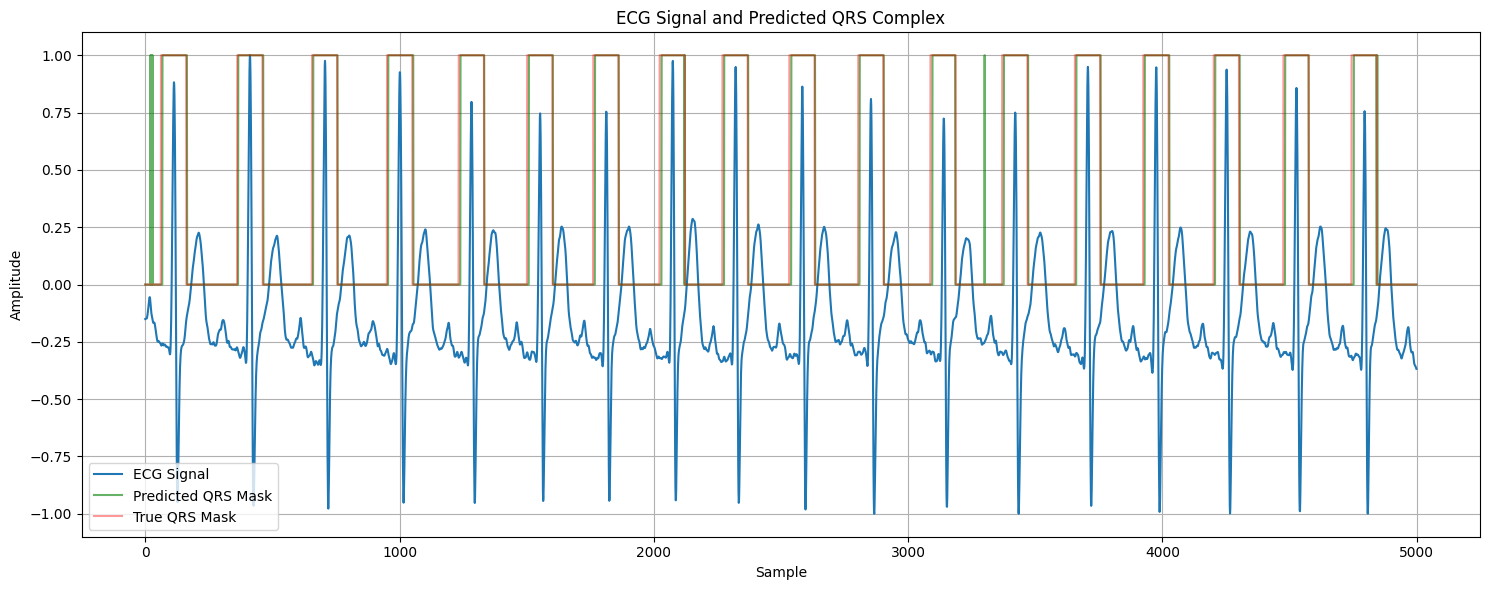

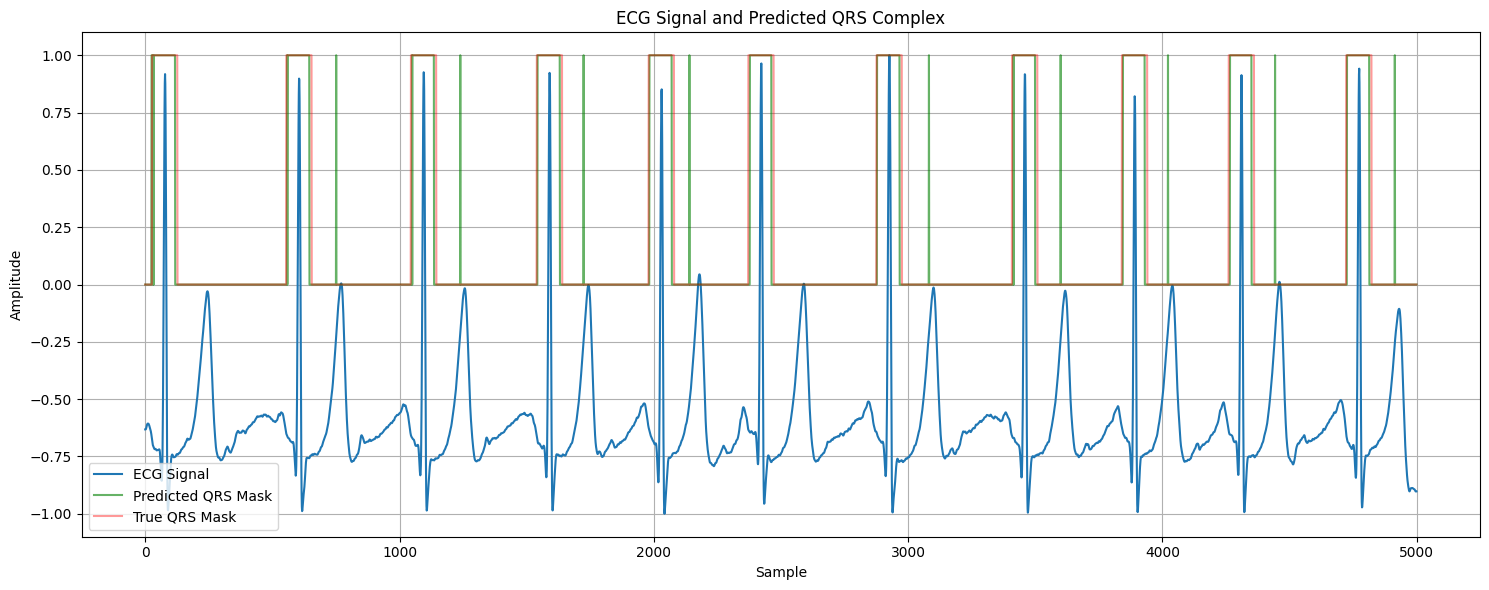

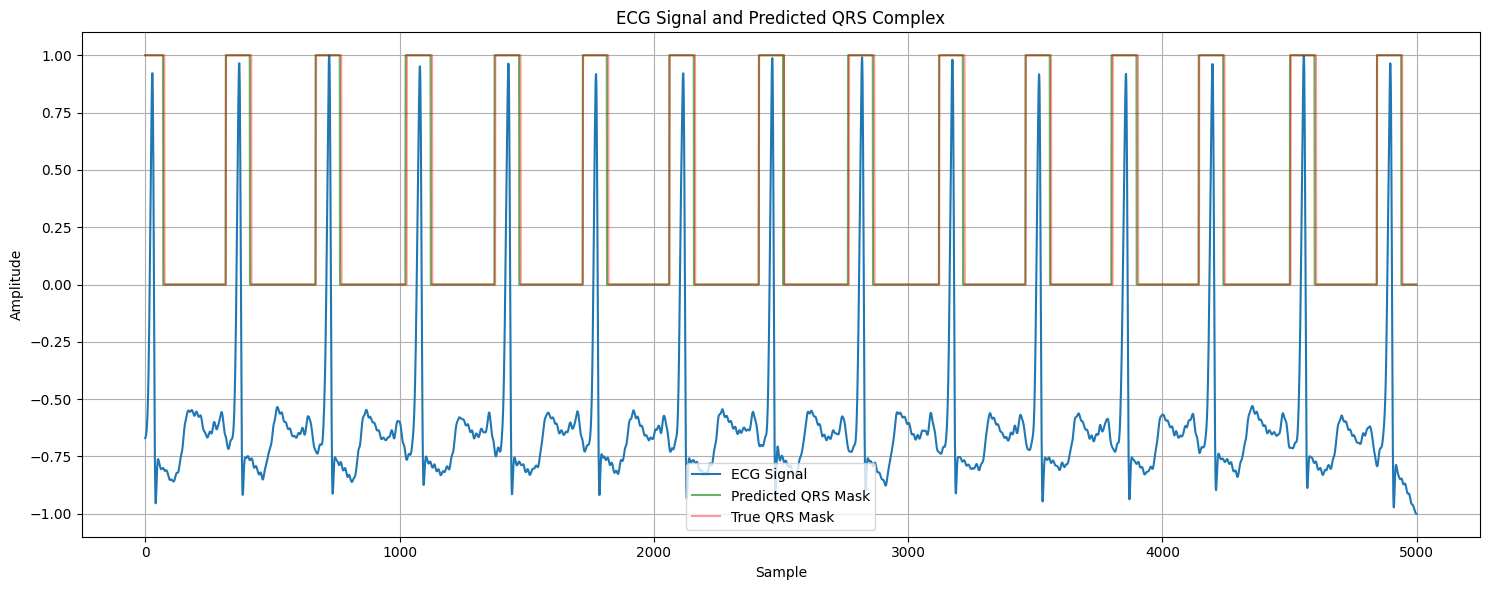

In [10]:
# UNet 모델을 사용하여 QRS 컴플렉스 예측 및 시각화
def visualize_qrs_prediction(model, ecg_signal, true_mask=None, threshold=0.5):
    """
    UNet 모델을 사용하여 QRS 컴플렉스를 예측하고 시각화하는 함수
    
    Args:
        model: 학습된 UNet 모델
        ecg_signal: 입력 ECG 신호 (정규화된 형태)
        true_mask: 실제 QRS 마스크 (선택적)
        threshold: 예측 임계값 (기본값: 0.5)
    """
    # 모델을 평가 모드로 설정
    model.eval()
    
    # 입력 데이터 준비
    with torch.no_grad():
        input_tensor = torch.FloatTensor(ecg_signal).unsqueeze(0).to(device)
        
        outputs = model(input_tensor)
        probs = torch.sigmoid(outputs)
        
        # 예측 결과를 CPU로 이동하고 numpy 배열로 변환
        predicted_mask = (probs > threshold).float().cpu().squeeze().numpy()
    
    # 시각화
    plt.figure(figsize=(15, 6))
    
    # ECG 신호 그리기
    plt.plot(ecg_signal.squeeze().cpu().numpy(), label='ECG Signal')
    
    # 예측된 QRS 마스크 그리기
    plt.plot(predicted_mask, 'g', alpha=0.6, label='Predicted QRS Mask')
    # # 예측 확률값 그리기
    # plt.plot(probs.squeeze().cpu().numpy(), 'b', alpha=0.6, label='Prediction Probability')
    
    # 실제 마스크가 제공된 경우 함께 표시
    if true_mask is not None:
        plt.plot(true_mask.squeeze().cpu().numpy(), 'r', alpha=0.4, label='True QRS Mask')
    
    plt.title('ECG Signal and Predicted QRS Complex')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


for i in range(0, 10):
    test_ecg, test_mask, _ = test_dataset[i]
    visualize_qrs_prediction(unet_model, test_ecg, test_mask, threshold=best_threshold)


# R-peak 검출 모델 및 데이터셋 정의

In [11]:

# QRS 복합체 회귀 모델 정의
class RpeakRegressionModel(nn.Module):
    """
    - 각 QRS 복합체는 32 길이로 리샘플링됨
    - U-Net과 동일한 컨볼루션 레이어 가중치 크기와 채널 수 사용
    - 2개의 인코딩 블록과 2개의 FC 레이어로 구성
    """
    def __init__(self, in_channels=1):
        super(RpeakRegressionModel, self).__init__()
        
        self.enc1 = EncodingBlock(in_channels, 16)
        self.enc2 = EncodingBlock(16, 32)
        
        # 글로벌 평균 풀링 적용
        self.pool = nn.AdaptiveAvgPool1d(1)
        
        # 회귀를 위한 완전 연결 계층
        self.fc1 = nn.Linear(32, 64)
        self.fc2 = nn.Linear(64, 1)  # 회귀 출력을 위한 단일 값
        
    def forward(self, x):
        x = self.enc1(x)
        x = self.enc2(x)
        
        x = self.pool(x)
        x = x.view(x.size(0), -1)  
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [12]:
def extract_qrs_complexes(ecg_signal, qrs_mask, fixed_length=32, r_peaks=None):
    """
    ECG 신호에서 QRS 컴플렉스를 추출하고 고정 길이로 리샘플링
    주어진 R-peak 위치도 함께 리샘플링
    
    Args:
        ecg_signal: ECG 신호
        qrs_mask: QRS 컴플렉스 마스크
        fixed_length: 리샘플링할 고정 길이
        r_peaks: 원본 신호에서의 R-peak 위치 리스트 (선택적)
    """
    # 텐서를 numpy 배열로 변환
    if isinstance(ecg_signal, torch.Tensor):
        ecg_signal = ecg_signal.cpu().numpy()
    if isinstance(qrs_mask, torch.Tensor):
        qrs_mask = qrs_mask.cpu().numpy()
    
    # 차원 확인 및 조정
    if len(ecg_signal.shape) > 1:
        ecg_signal = ecg_signal.squeeze()
    if len(qrs_mask.shape) > 1:
        qrs_mask = qrs_mask.squeeze()
    
    # QRS 컴플렉스 구간 찾기
    qrs_regions = []
    in_qrs = False
    start_idx = 0
    
    # 예측된 QRS 값에 따라서 시작과 끝 지점(구간) 찾기
    for i, val in enumerate(qrs_mask):
        if val > 0.5 and not in_qrs:  # QRS 시작
            in_qrs = True
            start_idx = i
        elif val <= 0.5 and in_qrs:  # QRS 종료
            in_qrs = False
            qrs_regions.append((start_idx, i))
    # 마지막 QRS가 신호 끝까지 계속되는 경우
    if in_qrs:
        qrs_regions.append((start_idx, len(qrs_mask)))
    # QRS 컴플렉스 추출 및 리샘플링
    resampled_qrs = []
    resampled_r_peaks = []
    
    for i, (start, end) in enumerate(qrs_regions):
        if end - start < 5:  # 너무 짧은 QRS는 무시(5 samples)
            continue
        qrs_complex = ecg_signal[start:end]
        
        # 리샘플링 (고정 길이로)
        resampled = signal.resample(qrs_complex, fixed_length)
        resampled_qrs.append(resampled)
        
        # R-peak 위치 리샘플링
        if r_peaks is not None and i < len(r_peaks):
            # 주어진 R-peak이 현재 QRS 영역 내에 있는지 확인
            r_peak = r_peaks[i]
            if start <= r_peak < end:
                # 원본 영역 내에서의 상대적 위치 계산
                relative_pos = (r_peak - start) / (end - start)
                # 리샘플링된 영역에서의 위치 계산
                resampled_r_peak = int(relative_pos * fixed_length)
                resampled_r_peaks.append(resampled_r_peak)
        else:
            # R-peak이 주어지지 않은 경우 신호의 최대값 위치로 가정
            original_r_peak = np.argmax(qrs_complex)
            resampled_r_peak = int(original_r_peak * (fixed_length / len(qrs_complex)))
            resampled_r_peaks.append(resampled_r_peak)
    
    return np.array(resampled_qrs), qrs_regions, np.array(resampled_r_peaks)

def refine_qrs_mask(qrs_mask, min_qrs_width=35, max_qrs_width=60, min_gap=60):
    """
    QRS 마스크를 후처리하여 너무 좁은 QRS 영역 제거, 너무 넓은 QRS 영역 분할, 
    그리고 너무 가까운 QRS 영역 병합
    
    Args:
        qrs_mask: 원본 QRS 마스크
        min_qrs_width: 최소 QRS 너비 (샘플 수)
        max_qrs_width: 최대 QRS 너비 (샘플 수)
        min_gap: QRS 영역 간 최소 간격 (샘플 수)
    
    Returns:
        refined_mask: 정제된 QRS 마스크
    """
    # 마스크 복사
    refined_mask = qrs_mask.copy()
    
    # QRS 영역 찾기
    qrs_regions = []
    in_qrs = False
    start_idx = 0
    
    for i, val in enumerate(refined_mask):
        if val > 0.5 and not in_qrs:  # QRS 시작
            in_qrs = True
            start_idx = i
        elif val <= 0.5 and in_qrs:  # QRS 종료
            in_qrs = False
            qrs_regions.append((start_idx, i))
    
    # 마지막 QRS가 신호 끝까지 계속되는 경우
    if in_qrs:
        qrs_regions.append((start_idx, len(refined_mask)))
    
    # 너무 좁은 QRS 영역 제거
    valid_regions = []
    for start, end in qrs_regions:
        if end - start >= min_qrs_width:
            valid_regions.append((start, end))
        else:
            refined_mask[start:end] = 0  # 마스크에서 제거
    
    # 너무 넓은 QRS 영역 분할
    split_regions = []
    for start, end in valid_regions:
        width = end - start
        if width > max_qrs_width:
            # 신호 기반으로 분할점 찾기 (여기서는 간단히 중간점으로 분할)
            mid = start + width // 2
            split_regions.append((start, mid))
            split_regions.append((mid, end))
        else:
            split_regions.append((start, end))
    
    # 너무 가까운 QRS 영역 병합
    merged_regions = []
    if split_regions:
        current_start, current_end = split_regions[0]
        
        for i in range(1, len(split_regions)):
            next_start, next_end = split_regions[i]
            
            if next_start - current_end < min_gap:
                # 병합
                current_end = next_end
            else:
                merged_regions.append((current_start, current_end))
                current_start, current_end = next_start, next_end
        
        # 마지막 영역 추가
        merged_regions.append((current_start, current_end))
    
    # 정제된 마스크 생성
    refined_mask = np.zeros_like(qrs_mask)
    for start, end in merged_regions:
        refined_mask[start:end] = 1
    
    return refined_mask

def validate_r_peaks(ecg_signal, r_peak_locations, fs=500, min_rr_ms=200, max_rr_ms=2000):
    """
    생리학적 제약 조건을 기반으로 R-peak 위치 검증 및 보정
    
    Args:
        ecg_signal: ECG 신호
        r_peak_locations: 검출된 R-peak 위치 목록
        fs: 샘플링 주파수 (Hz)
        min_rr_ms: 최소 R-R 간격 (밀리초)
        max_rr_ms: 최대 R-R 간격 (밀리초)
    
    Returns:
        validated_peaks: 검증된 R-peak 위치 목록
    """
    if len(r_peak_locations) <= 1:
        return r_peak_locations
    
    # 샘플 단위로 변환
    min_rr_samples = int(min_rr_ms * fs / 1000)
    max_rr_samples = int(max_rr_ms * fs / 1000)
    
    # R-peak 위치 정렬
    r_peak_locations = sorted(r_peak_locations)
    
    # 검증된 R-peak 목록 초기화
    validated_peaks = [r_peak_locations[0]]  # 첫 번째 피크는 유지
    
    for i in range(1, len(r_peak_locations)):
        current_peak = r_peak_locations[i]
        last_valid_peak = validated_peaks[-1]
        rr_interval = current_peak - last_valid_peak
        
        # 최소 R-R 간격 검사
        if rr_interval < min_rr_samples:
            # 두 피크 중 더 높은 진폭을 가진 피크 선택
            if current_peak < len(ecg_signal) and last_valid_peak < len(ecg_signal):
                if abs(ecg_signal[current_peak]) > abs(ecg_signal[last_valid_peak]):
                    # 현재 피크가 더 강함 - 이전 피크 대체
                    validated_peaks[-1] = current_peak
            continue
        
        # 최대 R-R 간격 검사
        if rr_interval > max_rr_samples:
            # 놓친 R-peak가 있을 수 있음 - 중간에 피크 찾기 시도
            mid_point = (last_valid_peak + current_peak) // 2
            window_size = min(rr_interval // 4, 100)  # 검색 윈도우 크기
            
            # 중간 지점 주변에서 피크 찾기
            search_start = max(0, mid_point - window_size)
            search_end = min(len(ecg_signal), mid_point + window_size)
            
            if search_end > search_start:
                # 검색 윈도우 내에서 가장 큰 피크 찾기
                window_signal = np.abs(ecg_signal[search_start:search_end])
                max_idx = np.argmax(window_signal)
                potential_peak = search_start + max_idx
                
                # 충분히 큰 피크인지 확인
                if window_signal[max_idx] > 0.5 * abs(ecg_signal[last_valid_peak]):
                    validated_peaks.append(potential_peak)
        
        # 정상 R-R 간격 - 피크 추가
        validated_peaks.append(current_peak)
    
    return validated_peaks

def refine_r_peak_locations(ecg_signal, r_peak_locations, window_size=10):
    """
    R-peak 위치를 주변 윈도우에서 실제 최대값으로 정밀화
    
    Args:
        ecg_signal: ECG 신호
        r_peak_locations: 초기 R-peak 위치 목록
        window_size: 검색 윈도우 크기 (샘플 수)
    
    Returns:
        refined_peaks: 정밀화된 R-peak 위치 목록
    """
    refined_peaks = []
    
    for peak in r_peak_locations:
        # 검색 윈도우 범위 설정
        window_start = max(0, peak - window_size)
        window_end = min(len(ecg_signal), peak + window_size + 1)
        
        # 윈도우 내에서 최대값 위치 찾기
        window = ecg_signal[window_start:window_end]
        
        # 최대값 찾기
        local_max_idx = np.argmax(window)
        
        # 전체 신호에서의 위치로 변환
        refined_peak = window_start + local_max_idx
        refined_peaks.append(refined_peak)
    
    return refined_peaks

def r_peak_detection(ecg_signal, qrs_mask, rpeak_model, device, fs=500):
    """
    R-peak 검출 함수
    
    Args:
        ecg_signal: ECG 신호
        qrs_mask: QRS 마스크
        rpeak_model: R-peak 위치 예측 회귀 모델
        device: 연산 장치 (CPU 또는 GPU)
        fs: 샘플링 주파수 (Hz)
    
    Returns:
        r_peak_locations: 검출된 R-peak 위치 목록
    """
    # 1. QRS 마스크 후처리
    refined_mask = refine_qrs_mask(qrs_mask)
    # 2. QRS 컴플렉스 추출
    qrs_complexes, qrs_regions, _ = extract_qrs_complexes(ecg_signal, refined_mask)
    if len(qrs_complexes) == 0:
        return []
    # 3. 각 QRS 컴플렉스에서 R 피크 위치 예측
    r_peak_locations = []
    with torch.no_grad():
        for i, qrs in enumerate(qrs_complexes):
            # 입력 텐서 형태 확인 및 조정
            qrs_tensor = torch.FloatTensor(qrs).unsqueeze(0).unsqueeze(0).to(device)
            
            # 정규화된 위치 예측 (0~1 사이 값)
            normalized_position = rpeak_model(qrs_tensor).item()
            normalized_position = max(0, min(1, normalized_position))
            
            # 정규화된 위치를 실제 샘플 위치로 변환
            start, end = qrs_regions[i]
            r_peak_idx = start + int(normalized_position * (end - start))
            r_peak_locations.append(r_peak_idx)
    # 4. R-peak 위치 정밀화
    refined_peaks = refine_r_peak_locations(ecg_signal, r_peak_locations)
    
    # 5. 생리학적 제약 기반 검증
    validated_peaks = validate_r_peaks(ecg_signal, refined_peaks, fs)
    
    return validated_peaks

def predict_r_peaks(ecg_signal, qrs_mask, rpeak_model, device, fs=500):
    """
    R-peak 검출 함수
    
    Args:
        ecg_signal: ECG 신호 데이터
        qrs_mask: QRS 복합체 마스크 (U-Net 예측 결과)
        rpeak_model: R 피크 위치 예측 회귀 모델
        device: 연산 장치 (CPU 또는 GPU)
        fs: 샘플링 주파수 (Hz)
        
    Returns:
        dict: R-peak 검출 결과와 신호 품질 정보를 포함한 딕셔너리
    """
    rpeak_model.to(device)
    rpeak_model.eval()
    
    # 텐서를 numpy 배열로 변환
    if isinstance(ecg_signal, torch.Tensor):
        ecg_signal = ecg_signal.cpu().numpy()
    if isinstance(qrs_mask, torch.Tensor):
        qrs_mask = qrs_mask.cpu().numpy()
    
    # 차원 확인 및 조정
    if len(ecg_signal.shape) > 1:
        ecg_signal = ecg_signal.squeeze()
    if len(qrs_mask.shape) > 1:
        qrs_mask = qrs_mask.squeeze()
    
    # R-peak 검출
    r_peak_locations = r_peak_detection(ecg_signal, qrs_mask, rpeak_model, device, fs)
    
    # 결과 딕셔너리 생성
    result = {
        'R-peak Regression': {
            'original_rpeaks': np.array(r_peak_locations),
            'corrected_rpeaks': np.array(r_peak_locations),
            'plot_signal': ecg_signal
        }
    }
    
    return result

# 정답 값과 모델 예측 결과 비교
def compare_predictions_with_ground_truth(test_dataset, unet_model, rpeak_model, device, best_threshold, num_samples=5):
    """
    모델의 예측 결과와 정답 값을 비교하여 시각화하는 함수
    
    Parameters:
    -----------
    test_dataset : Dataset
        테스트 데이터셋
    unet_model : torch.nn.Module
        학습된 U-Net 모델
    rpeak_model : torch.nn.Module
        학습된 R-peak 회귀 모델
    device : torch.device
        연산을 수행할 디바이스
    best_threshold : float
        U-Net 모델의 출력을 이진화하기 위한 최적 임계값
    num_samples : int, optional
        시각화할 샘플 수 (기본값: 5)
    """
    plt.figure(figsize=(20, 4 * num_samples))
    
    for i in range(min(num_samples, len(test_dataset))):
        test_ecg, test_mask, test_rpeaks = test_dataset[i]
        
        # U-Net 모델로 QRS 마스크 예측
        with torch.no_grad():
            input_tensor = test_ecg.unsqueeze(0).to(device)
            outputs = unet_model(input_tensor)
            qrs_mask = (torch.sigmoid(outputs) > best_threshold).float().cpu().squeeze().numpy()
        
        # 앙상블 방법으로 R-peak 검출
        result = extract_ecg_and_rpeaks(test_ecg.numpy()[0], 500, 0.5, 40, min_votes_ratio=0.5)
        
        # 회귀 모델로 R-peak 예측
        model_rpeaks = predict_r_peaks(test_ecg.unsqueeze(0), qrs_mask, rpeak_model, device, 500)
        
        # 시각화
        plt.subplot(num_samples, 1, i+1)
        plt.plot(test_ecg.numpy()[0], label='ECG Signal')
        
        # 텐서를 numpy 배열로 변환 (test_mask만 처리)
        if isinstance(test_ecg, torch.Tensor):
            test_ecg = test_ecg.cpu().numpy()
            
        # 텐서를 numpy 배열로 변환 (test_mask만 처리)
        if isinstance(test_mask, torch.Tensor):
            test_mask = test_mask.cpu().numpy()
        
        # 차원 확인 및 조정 (test_mask만 처리)
        if len(test_mask.shape) > 1:
            test_mask = test_mask.squeeze()
        # 정제된 QRS 마스크 그리기
        refined_mask = refine_qrs_mask(qrs_mask)
        plt.fill_between(range(len(refined_mask)), 0, refined_mask * np.max(test_ecg[0]) * 0.3, 
                        color='red', alpha=0.3, label='Predicted QRS Mask')
        
        # 실제 QRS 마스크 그리기
        plt.fill_between(range(len(test_mask)), 0, test_mask * np.max(test_ecg[0]) * 0.2, 
                        color='green', alpha=0.3, label='Ground Truth QRS Mask')
        test_rpeaks = correct_rpeaks(test_ecg[0], test_rpeaks, 500)
        
        # 정답 R-peak 표시
        if len(test_rpeaks) > 0:
            plt.scatter(test_rpeaks, test_ecg[0][test_rpeaks], 
                       color='green', marker='o', s=100, label='Ground Truth R-peaks')
        
        # 앙상블 방법으로 검출된 R-peak 표시
        ensemble_rpeaks = result['ensemble_rpeaks']
        if len(ensemble_rpeaks) > 0:
            plt.scatter(ensemble_rpeaks, test_ecg[0][ensemble_rpeaks], 
                       color='blue', marker='*', s=100, label='Ensemble R-peaks')
        
        # 회귀 모델로 예측된 R-peak 표시
        regression_rpeaks = model_rpeaks['R-peak Regression']['corrected_rpeaks']
    
        model_result = tolerance_matching(test_rpeaks, regression_rpeaks)
        ensemble_result = tolerance_matching(test_rpeaks, ensemble_rpeaks)
        if len(regression_rpeaks) > 0:
            plt.scatter(regression_rpeaks, test_ecg[0][regression_rpeaks], 
                       color='red', marker='x', s=100, label='Regression Model R-peaks')
        plt.title(f"Sample {i+1} - ECG Signal and R-peak Comparison_{model_result['F1_score']}_{ensemble_result['F1_score']}")
        plt.xlabel('Samples')
        plt.ylabel('Amplitude')
        plt.legend(loc='upper left')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def create_regression_dataset(data_loader, device):
    X_reg = []
    y_reg = []
    
    # device 설정
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    with torch.no_grad():
        for inputs, labels, r_peaks_idx in tqdm(data_loader, desc="회귀 데이터셋 생성 중"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # 배치의 각 샘플에 대해 처리
            for i in range(inputs.size(0)):
                ecg = inputs[i].cpu().numpy()
                pred_mask = labels[i][0]  # 첫 번째 채널 선택
                # QRS 복합체 추출 및 리샘플링
                qrs_complexes, qrs_regions, _ = extract_qrs_complexes(ecg, pred_mask, fixed_length=32, r_peaks=r_peaks_idx)
                
                if len(qrs_complexes) == 0:
                    continue
                
                # 각 QRS 복합체에 대해 R 피크 위치 찾기
                for j, (qrs, region) in enumerate(zip(qrs_complexes, qrs_regions)):
                    start, end = region
                    qrs_original = ecg[0, start:end]  # 원본 QRS 복합체
                    
                    if len(qrs_original) < 5:  # 너무 짧은 QRS는 무시
                        continue
                    
                    r_peak_idx = np.argmax(qrs_original)
                    # R 피크 위치를 0~1 사이로 정규화
                    normalized_position = r_peak_idx / (len(qrs_original) - 1) if len(qrs_original) > 1 else 0.5
                    
                    # 데이터셋에 추가
                    X_reg.append(qrs.reshape(1, -1))  # 채널 차원 추가 (1, 32)
                    y_reg.append([normalized_position])
    
    # 텐서로 변환
    X_reg = torch.FloatTensor(np.array(X_reg))
    y_reg = torch.FloatTensor(np.array(y_reg))
    
    return X_reg, y_reg

In [13]:
unet_model = UNet(in_channels=1, num_classes=1).to(device)
unet_model.load_state_dict(torch.load('best_unet_model.pth'))


# 회귀 모델 학습 데이터셋 생성
X_reg_train, y_reg_train = create_regression_dataset(train_loader, device)
X_reg_val, y_reg_val = create_regression_dataset(val_loader, device)
X_reg_test, y_reg_test = create_regression_dataset(test_loader, device)


# 회귀 모델 데이터 로더 생성
reg_train_dataset = TensorDataset(X_reg_train, y_reg_train)
reg_val_dataset = TensorDataset(X_reg_val, y_reg_val)
reg_test_dataset = TensorDataset(X_reg_test, y_reg_test)


reg_train_loader = DataLoader(reg_train_dataset, batch_size=64, shuffle=True, num_workers=8, pin_memory=True, drop_last=True)
reg_val_loader = DataLoader(reg_val_dataset, batch_size=64, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)
reg_test_loader = DataLoader(reg_test_dataset, batch_size=1, shuffle=False, num_workers=8, pin_memory=True)


# 회귀 모델 초기화 및 학습
rpeak_model = QRSRegressionModel()

/tmp/ipykernel_1480871/1396578218.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet_model.load_state_dict(torch.load('best_unet_model.pth'))
회귀 데이터셋 생성 중: 100%|██████

# R-peak 검출 모델 학습

In [14]:
train_qrs_regression(rpeak_model, reg_train_loader, reg_val_loader, device, epochs=50)

에포크 1/50, 학습 손실: 0.0065, 검증 손실: 0.0027
에포크 2/50, 학습 손실: 0.0022, 검증 손실: 0.0022
에포크 3/50, 학습 손실: 0.0019, 검증 손실: 0.0023
에포크 4/50, 학습 손실: 0.0018, 검증 손실: 0.0017
에포크 5/50, 학습 손실: 0.0016, 검증 손실: 0.0014
에포크 6/50, 학습 손실: 0.0015, 검증 손실: 0.0014
에포크 7/50, 학습 손실: 0.0014, 검증 손실: 0.0017
에포크 8/50, 학습 손실: 0.0013, 검증 손실: 0.0015
에포크 9/50, 학습 손실: 0.0013, 검증 손실: 0.0016
에포크 10/50, 학습 손실: 0.0011, 검증 손실: 0.0011
에포크 11/50, 학습 손실: 0.0011, 검증 손실: 0.0013
에포크 12/50, 학습 손실: 0.0010, 검증 손실: 0.0009
에포크 13/50, 학습 손실: 0.0010, 검증 손실: 0.0010
에포크 14/50, 학습 손실: 0.0010, 검증 손실: 0.0011
에포크 15/50, 학습 손실: 0.0009, 검증 손실: 0.0016
에포크 16/50, 학습 손실: 0.0009, 검증 손실: 0.0009
에포크 17/50, 학습 손실: 0.0008, 검증 손실: 0.0009
에포크 18/50, 학습 손실: 0.0008, 검증 손실: 0.0009
에포크 19/50, 학습 손실: 0.0008, 검증 손실: 0.0009
에포크 20/50, 학습 손실: 0.0008, 검증 손실: 0.0008
에포크 21/50, 학습 손실: 0.0008, 검증 손실: 0.0009
에포크 22/50, 학습 손실: 0.0008, 검증 손실: 0.0008
에포크 23/50, 학습 손실: 0.0008, 검증 손실: 0.0009
에포크 24/50, 학습 손실: 0.0007, 검증 손실: 0.0008
Early stopping 발동: 5회 동안 검증 손실이 개선되지 않았습니다.


# R-peak 검출 모델 검증


In [15]:

X_reg_test, y_reg_test = create_regression_dataset(test_loader, device)
reg_test_dataset = TensorDataset(X_reg_test, y_reg_test)
reg_test_loader = DataLoader(reg_test_dataset, batch_size=1, shuffle=False, num_workers=8, pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet_model = UNet(in_channels=1, num_classes=1).to(device)
unet_model.load_state_dict(torch.load('best_unet_model.pth', weights_only=True))
unet_model.eval()

# R 피크 회귀 네트워크 학습
rpeak_model = QRSRegressionModel().to(device)
rpeak_model.load_state_dict(torch.load('best_qrs_regression_model.pth'))
rpeak_model.eval()

accuracy, precision, recall, f1, best_threshold = evaluate_model_unet(unet_model, test_loader, device)
rmse, mae = evaluate_model_rpeak(rpeak_model, reg_test_loader, device)


회귀 데이터셋 생성 중: 100%|██████████| 1628/1628 [00:20<00:00, 80.04it/s] 
/tmp/ipykernel_1480871/1987221529.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rpeak_model.load_st

최적 임계값: 0.350
정확도: 0.9573
정밀도: 0.9208
재현율: 0.9020
F1 점수: 0.9113


모델 평가 중: 100%|██████████| 19896/19896 [01:08<00:00, 288.37it/s]

RMSE: 0.0258
MAE: 0.0070


In [16]:
# 정답 값과 모델 예측 결과 비교
def compare_predictions_with_ground_truth(test_loader, unet_model, rpeak_model, device, best_threshold, num_samples=None, plot=True, save=False):
    """
    모델의 예측 결과와 정답 값을 비교하여 시각화하는 함수
    
    Parameters:
    -----------
    test_loader : DataLoader
        테스트 데이터 로더
    unet_model : torch.nn.Module
        학습된 U-Net 모델
    rpeak_model : torch.nn.Module
        학습된 R-peak 회귀 모델
    device : torch.device
        연산을 수행할 디바이스
    best_threshold : float
        U-Net 모델의 출력을 이진화하기 위한 최적 임계값
    num_samples : int, tuple, list, optional
        시각화할 샘플 수 또는 특정 인덱스/범위 
        - int: 처음부터 해당 개수만큼 샘플 처리
        - tuple: (시작 인덱스, 끝 인덱스)로 범위 지정
        - list: 처리할 특정 인덱스 목록
        - None: 모든 샘플 처리 (기본값)
    plot : bool, optional
        결과를 시각화할지 여부 (기본값: True)
    """
    # num_samples 처리 로직
    if num_samples is None:
        # 모든 샘플 처리
        process_all = True
        max_samples = len(test_loader)
        indices_to_process = range(max_samples)
    elif isinstance(num_samples, int):
        # 처음부터 num_samples 개수만큼 처리
        process_all = False
        max_samples = min(num_samples, len(test_loader))
        indices_to_process = range(max_samples)
    elif isinstance(num_samples, tuple) and len(num_samples) == 2:
        # 시작과 끝 인덱스 범위 처리
        process_all = False
        start_idx, end_idx = num_samples
        end_idx = min(end_idx, len(test_loader))
        indices_to_process = range(start_idx, end_idx)
        max_samples = len(indices_to_process)
    elif isinstance(num_samples, list):
        # 특정 인덱스 목록 처리
        process_all = False
        indices_to_process = [idx for idx in num_samples if idx < len(test_loader)]
        max_samples = len(indices_to_process)
    else:
        # 잘못된 입력 처리
        process_all = True
        max_samples = len(test_loader)
        indices_to_process = range(max_samples)
    
    sample_count = 0
    total_reg_TP, total_reg_FP, total_reg_FN, total_ens_TP, total_ens_FP, total_ens_FN, total_final_TP, total_final_FP, total_final_FN = 0, 0, 0, 0, 0, 0, 0, 0, 0
    
    # 데이터 로더를 리스트로 변환하여 인덱스 접근 가능하게 함
    test_data_list = list(test_loader)
    
    for idx in tqdm(indices_to_process, desc="모델 평가 중"):
        test_ecg, test_mask, test_rpeaks = test_data_list[idx]
        test_ecg = test_ecg.to(device)
        test_mask = test_mask.to(device)
        
        # U-Net 모델로 QRS 마스크 예측
        with torch.no_grad():
            outputs = unet_model(test_ecg)
            qrs_mask = (torch.sigmoid(outputs) > best_threshold).float().cpu().squeeze().numpy()
        
        # 앙상블 방법으로 R-peak 검출
        current_ecg_np = test_ecg.cpu().numpy().squeeze()
        result = extract_ecg_and_rpeaks(current_ecg_np, 500, 0.5, 40, min_votes_ratio=0.5)
        
        # 회귀 모델로 R-peak 예측
        model_rpeaks = predict_r_peaks(test_ecg, qrs_mask, rpeak_model, device, 500)
        # 모델 결과 계산
        current_ecg_np = test_ecg.cpu().numpy().squeeze()
        current_mask_np = test_mask.cpu().numpy()
        
        # 차원 확인 및 조정
        if len(current_mask_np.shape) > 1:
            current_mask_np = current_mask_np.squeeze()
        
        # 정제된 QRS 마스크 생성
        refined_mask = refine_qrs_mask(qrs_mask)
        
        # R-peak 관련 데이터 준비
        current_rpeaks_np = correct_rpeaks(current_ecg_np, test_rpeaks, 500)
        
        # 앙상블 방법으로 검출된 R-peak
        ensemble_rpeaks = result['ensemble_rpeaks']
        
        # 회귀 모델로 예측된 R-peak
        regression_rpeaks = model_rpeaks['R-peak Regression']['corrected_rpeaks']
        
        # 시각화를 위한 그림 생성
        plt.figure(figsize=(20, 15))
        
        # 첫 번째 서브플롯 - 앙상블 R-peak
        ax1 = plt.subplot(3, 1, 1)
        ax1.plot(current_ecg_np, label='ECG Signal')
        
        # 정답 R-peak 표시
        if len(current_rpeaks_np) > 0:
            ax1.scatter(current_rpeaks_np, current_ecg_np[current_rpeaks_np], 
                      color='green', marker='o', s=100, label='Ground Truth R-peaks')
        
        # 앙상블 R-peak 표시
        if len(ensemble_rpeaks) > 0:
            ax1.scatter(ensemble_rpeaks, current_ecg_np[ensemble_rpeaks], 
                      color='blue', marker='*', s=100, label='Ensemble R-peaks')
        
        ax1.set_title(f"Sample {idx} - Ensemble R-peak ({result['signal_quality']:.2f})")
        ax1.set_xlabel('Samples')
        ax1.set_ylabel('Amplitude')
        ax1.legend(loc='upper left')
        ax1.grid(True, alpha=0.3)
        
        # 두 번째 서브플롯 - 회귀 모델 R-peak
        ax2 = plt.subplot(3, 1, 2)
        ax2.plot(current_ecg_np, label='ECG Signal')
        
        # 정제된 QRS 마스크와 실제 QRS 마스크 그리기
        max_ecg = np.max(current_ecg_np)
        ax2.fill_between(range(len(refined_mask)), 0, refined_mask * max_ecg * 0.3, 
                        color='red', alpha=0.3, label='Predicted QRS Mask')
        ax2.fill_between(range(len(current_mask_np)), 0, current_mask_np * max_ecg * 0.2, 
                        color='green', alpha=0.3, label='Ground Truth QRS Mask')
        
        # 정답 R-peak와 회귀 모델 R-peak 표시
        if len(current_rpeaks_np) > 0:
            ax2.scatter(current_rpeaks_np, current_ecg_np[current_rpeaks_np], 
                      color='green', marker='o', s=100, label='Ground Truth R-peaks')
        
        if len(regression_rpeaks) > 0:
            ax2.scatter(regression_rpeaks, current_ecg_np[regression_rpeaks], 
                      color='red', marker='x', s=100, label='Regression Model R-peaks')
        
        ax2.set_title(f"Sample {idx} - Model Predicted R-peak ({result['signal_quality']:.2f})")
        ax2.set_xlabel('Samples')
        ax2.set_ylabel('Amplitude')
        ax2.legend(loc='upper left')
        ax2.grid(True, alpha=0.3)
        
        # 세 번째 서브플롯 - 최종 앙상블 R-peak
        ax3 = plt.subplot(3, 1, 3)
        ax3.plot(current_ecg_np, label='ECG Signal')
        
        # 정답 R-peak 표시
        if len(current_rpeaks_np) > 0:
            ax3.scatter(current_rpeaks_np, current_ecg_np[current_rpeaks_np], 
                      color='green', marker='o', s=100, label='Ground Truth R-peaks')
        
        # 신호 품질에 따른 최종 R-peak 결정 전략
        signal_quality = result['signal_quality']
        final_rpeaks = []

        # 신호 품질 구간 세분화 (간소화 버전)
        if signal_quality > 0.85:  # 높은 신호 품질
            # 앙상블 결과 우선 사용, 회귀 모델로 보완
            final_rpeaks = ensemble_rpeaks.copy()
            
            # 앙상블에서 놓친 R-peak를 회귀 모델에서 찾아 추가
            for reg_peak in regression_rpeaks:
                if len(ensemble_rpeaks) > 0:
                    # 가장 가까운 앙상블 피크와 150ms 이상 차이나면 추가
                    min_distance = min(abs(np.array(ensemble_rpeaks) - reg_peak))
                    if min_distance > int(0.15 * 500):
                        final_rpeaks = np.append(final_rpeaks, reg_peak)
                else:
                    final_rpeaks = np.append(final_rpeaks, reg_peak)
                    
        elif signal_quality > 0.6:  # 중간 신호 품질
            # 두 모델의 결과를 결합 (회귀 모델 가중치 높게)
            final_rpeaks = regression_rpeaks.copy()
            
            # 회귀 모델에 없는 앙상블 피크 추가 검토
            for ens_peak in ensemble_rpeaks:
                if len(regression_rpeaks) > 0:
                    min_distance = min(abs(np.array(regression_rpeaks) - ens_peak))
                    if min_distance > int(0.1 * 500):  # 100ms 이상 차이나면 추가
                        final_rpeaks = np.append(final_rpeaks, ens_peak)
                else:
                    final_rpeaks = np.append(final_rpeaks, ens_peak)
                    
        else:  # 낮은 신호 품질
            # 두 모델 모두에서 검출된 피크만 신뢰
            final_rpeaks = np.array([], dtype=int)
            for peak in regression_rpeaks:
                if peak in ensemble_rpeaks or min(abs(np.array(ensemble_rpeaks) - peak)) < int(0.05 * 500):
                    final_rpeaks = np.append(final_rpeaks, peak)
            
            # 결과가 너무 적으면 회귀 모델 결과 사용
            if len(final_rpeaks) < 3 and len(regression_rpeaks) >= 3:
                final_rpeaks = regression_rpeaks.copy()
                        
        
        # 중복 제거 및 정렬
        final_rpeaks = sorted(list(set(final_rpeaks.astype(int))))
        
        # 성능 평가
        reg_result = tolerance_matching(test_rpeaks, regression_rpeaks)
        ens_result = tolerance_matching(test_rpeaks, ensemble_rpeaks)
        final_result = tolerance_matching(test_rpeaks, final_rpeaks)
        
        total_reg_TP += reg_result['TP']
        total_reg_FP += reg_result['FP']
        total_reg_FN += reg_result['FN']
        total_ens_TP += ens_result['TP']
        total_ens_FP += ens_result['FP']
        total_ens_FN += ens_result['FN']
        total_final_TP += final_result['TP']
        total_final_FP += final_result['FP']
        total_final_FN += final_result['FN']
        # 최종 앙상블 R-peak 표시
        if len(final_rpeaks) > 0:
            ax3.scatter(final_rpeaks, current_ecg_np[final_rpeaks], 
                      color='purple', marker='^', s=100, label='Final Ensemble R-peaks')
        
        ax3.set_title(f"Sample {idx} - Final Ensemble R-peaks ({result['signal_quality']:.2f})")
        ax3.set_xlabel('Samples')
        ax3.set_ylabel('Amplitude')
        ax3.legend(loc='upper left')
        ax3.grid(True, alpha=0.3)
        
        # 레이아웃 조정 및 저장/표시
        plt.tight_layout()
        
        if save:
            os.makedirs("results/ai_results", exist_ok=True)
            plt.savefig(f"results/ai_results/sample_{idx}.png")
        if plot:
            plt.show()
        else:
            plt.close()  # 메모리 누수 방지를 위해 표시하지 않는 경우 닫기
        
        sample_count += 1
        
    reg_accuracy = total_reg_TP / (total_reg_TP + total_reg_FP + total_reg_FN) if (total_reg_TP + total_reg_FP + total_reg_FN) > 0 else 0
    reg_precision = total_reg_TP / (total_reg_TP + total_reg_FP) if (total_reg_TP + total_reg_FP) > 0 else 0
    reg_recall = total_reg_TP / (total_reg_TP + total_reg_FN) if (total_reg_TP + total_reg_FN) > 0 else 0
    reg_f1 = 2 * reg_precision * reg_recall / (reg_precision + reg_recall) if (reg_precision + reg_recall) > 0 else 0
    ens_accuracy = total_ens_TP / (total_ens_TP + total_ens_FP + total_ens_FN) if (total_ens_TP + total_ens_FP + total_ens_FN) > 0 else 0
    ens_precision = total_ens_TP / (total_ens_TP + total_ens_FP) if (total_ens_TP + total_ens_FP) > 0 else 0
    ens_recall = total_ens_TP / (total_ens_TP + total_ens_FN) if (total_ens_TP + total_ens_FN) > 0 else 0
    ens_f1 = 2 * ens_precision * ens_recall / (ens_precision + ens_recall) if (ens_precision + ens_recall) > 0 else 0
    final_accuracy = total_final_TP / (total_final_TP + total_final_FP + total_final_FN) if (total_final_TP + total_final_FP + total_final_FN) > 0 else 0
    final_precision = total_final_TP / (total_final_TP + total_final_FP) if (total_final_TP + total_final_FP) > 0 else 0
    final_recall = total_final_TP / (total_final_TP + total_final_FN) if (total_final_TP + total_final_FN) > 0 else 0
    final_f1 = 2 * final_precision * final_recall / (final_precision + final_recall) if (final_precision + final_recall) > 0 else 0
        
    # 회귀 모델과 앙상블 모델의 성능 비교 결과
    print("\n===== 회귀 모델과 앙상블 모델 성능 비교 =====")
    print(f"회귀 모델 R-peak 검출 성능:")
    print(f"  - 정밀도(Precision): {reg_precision:.4f}")
    print(f"  - 재현율(Recall): {reg_recall:.4f}")
    print(f"  - F1 점수: {reg_f1:.4f}")
    print(f"  - 정확도: {reg_accuracy:.4f}")
    print(f"  - TP: {total_reg_TP}, FP: {total_reg_FP}, FN: {total_reg_FN}")
    
    print("\n앙상블 모델(Algorithm) R-peak 검출 성능:")
    print(f"  - 정밀도(Precision): {ens_precision:.4f}")
    print(f"  - 재현율(Recall): {ens_recall:.4f}")
    print(f"  - F1 점수: {ens_f1:.4f}")
    print(f"  - 정확도: {ens_accuracy:.4f}")
    print(f"  - TP: {total_ens_TP}, FP: {total_ens_FP}, FN: {total_ens_FN}")
    
    print("\n최종 앙상블 모델(AI+Algorithm) R-peak 검출 성능:")
    print(f"  - 정밀도(Precision): {final_precision:.4f}")
    print(f"  - 재현율(Recall): {final_recall:.4f}")
    print(f"  - F1 점수: {final_f1:.4f}")
    print(f"  - 정확도: {final_accuracy:.4f}")
    print(f"  - TP: {total_final_TP}, FP: {total_final_FP}, FN: {total_final_FN}")
    
    # 앙상블 대비 회귀 모델의 성능 향상 비율 계산
    accuracy_improvement = ((reg_accuracy - ens_accuracy) / ens_accuracy * 100) if ens_accuracy > 0 else float('inf')
    f1_improvement = ((reg_f1 - ens_f1) / ens_f1 * 100) if ens_f1 > 0 else float('inf')
    precision_improvement = ((reg_precision - ens_precision) / ens_precision * 100) if ens_precision > 0 else float('inf')
    recall_improvement = ((reg_recall - ens_recall) / ens_recall * 100) if ens_recall > 0 else float('inf')
    
    print("\nRule-based 모델 대비 회귀 모델의 성능 향상 비율:")
    print(f"  - 정확도 향상: {accuracy_improvement:.2f}%")
    print(f"  - F1 점수 향상: {f1_improvement:.2f}%")
    print(f"  - 정밀도 향상: {precision_improvement:.2f}%")
    print(f"  - 재현율 향상: {recall_improvement:.2f}%")
    
    # 앙상블 대비 최종 앙상블 모델의 성능 향상 비율 계산
    accuracy_improvement = ((final_accuracy - ens_accuracy) / ens_accuracy * 100) if ens_accuracy > 0 else float('inf')
    f1_improvement = ((final_f1 - ens_f1) / ens_f1 * 100) if ens_f1 > 0 else float('inf')
    precision_improvement = ((final_precision - ens_precision) / ens_precision * 100) if ens_precision > 0 else float('inf')
    recall_improvement = ((final_recall - ens_recall) / ens_recall * 100) if ens_recall > 0 else float('inf')
    
    print("\nRule-based 모델 대비 최종 앙상블 모델의 성능 향상 비율:")
    print(f"  - 정확도 향상: {accuracy_improvement:.2f}%")
    print(f"  - F1 점수 향상: {f1_improvement:.2f}%")
    print(f"  - 정밀도 향상: {precision_improvement:.2f}%")
    print(f"  - 재현율 향상: {recall_improvement:.2f}%")
    
    # 회귀 모델 대비 최종 앙상블 모델의 성능 향상 비율 계산
    accuracy_improvement = ((final_accuracy - reg_accuracy) / reg_accuracy * 100) if reg_accuracy > 0 else float('inf')
    f1_improvement = ((final_f1 - reg_f1) / reg_f1 * 100) if reg_f1 > 0 else float('inf')
    precision_improvement = ((final_precision - reg_precision) / reg_precision * 100) if reg_precision > 0 else float('inf')
    recall_improvement = ((final_recall - reg_recall) / reg_recall * 100) if reg_recall > 0 else float('inf')
    
    print("\n회귀 모델 대비 최종 앙상블 모델의 성능 향상 비율:")
    print(f"  - 정확도 향상: {accuracy_improvement:.2f}%")
    print(f"  - F1 점수 향상: {f1_improvement:.2f}%")
    print(f"  - 정밀도 향상: {precision_improvement:.2f}%")
    print(f"  - 재현율 향상: {recall_improvement:.2f}%")
    


In [ ]:
compare_predictions_with_ground_truth(test_loader, unet_model, rpeak_model, device, best_threshold, num_samples=None, plot=False, save=False)

# ===== 회귀 모델과 앙상블 모델 성능 비교 =====
# 회귀 모델 R-peak 검출 성능:
#   - 정밀도(Precision): 0.9541
#   - 재현율(Recall): 0.9483
#   - F1 점수: 0.9512
#   - 정확도: 0.9069
#   - TP: 18868, FP: 908, FN: 1028

# 앙상블 모델(Algorithm) R-peak 검출 성능:
#   - 정밀도(Precision): 0.9468
#   - 재현율(Recall): 0.8744
#   - F1 점수: 0.9091
#   - 정확도: 0.8334
#   - TP: 17397, FP: 978, FN: 2499

# 최종 앙상블 모델(AI+Algorithm) R-peak 검출 성능:
#   - 정밀도(Precision): 0.9413
#   - 재현율(Recall): 0.9664
#   - F1 점수: 0.9537
#   - 정확도: 0.9115
#   - TP: 19227, FP: 1198, FN: 669

# Rule-based 모델 대비 회귀 모델의 성능 향상 비율:
#   - 정확도 향상: 8.82%
#   - F1 점수 향상: 4.63%
#   - 정밀도 향상: 0.77%
#   - 재현율 향상: 8.46%

# Rule-based 모델 대비 최종 앙상블 모델의 성능 향상 비율:
#   - 정확도 향상: 9.37%
#   - F1 점수 향상: 4.90%
#   - 정밀도 향상: -0.57%
#   - 재현율 향상: 10.52%

# 회귀 모델 대비 최종 앙상블 모델의 성능 향상 비율:
#   - 정확도 향상: 0.50%
#   - F1 점수 향상: 0.26%
#   - 정밀도 향상: -1.34%
#   - 재현율 향상: 1.90%


모델 평가 중: 100%|██████████| 1628/1628 [07:48<00:00,  3.48it/s]


===== 회귀 모델과 앙상블 모델 성능 비교 =====
회귀 모델 R-peak 검출 성능:
  - 정밀도(Precision): 0.9519
  - 재현율(Recall): 0.9695
  - F1 점수: 0.9606
  - 정확도: 0.9242
  - TP: 19289, FP: 974, FN: 607

앙상블 모델(Algorithm) R-peak 검출 성능:
  - 정밀도(Precision): 0.9468
  - 재현율(Recall): 0.8744
  - F1 점수: 0.9091
  - 정확도: 0.8334
  - TP: 17397, FP: 978, FN: 2499

최종 앙상블 모델(AI+Algorithm) R-peak 검출 성능:
  - 정밀도(Precision): 0.9393
  - 재현율(Recall): 0.9738
  - F1 점수: 0.9562
  - 정확도: 0.9162
  - TP: 19375, FP: 1252, FN: 521

Rule-based 모델 대비 회귀 모델의 성능 향상 비율:
  - 정확도 향상: 10.90%
  - F1 점수 향상: 5.66%
  - 정밀도 향상: 0.54%
  - 재현율 향상: 10.88%

Rule-based 모델 대비 최종 앙상블 모델의 성능 향상 비율:
  - 정확도 향상: 9.93%
  - F1 점수 향상: 5.18%
  - 정밀도 향상: -0.79%
  - 재현율 향상: 11.37%

회귀 모델 대비 최종 앙상블 모델의 성능 향상 비율:
  - 정확도 향상: -0.87%
  - F1 점수 향상: -0.46%
  - 정밀도 향상: -1.33%
  - 재현율 향상: 0.45%


: 